In [11]:
%run /home/user/besos/Matthias/tools/imports.ipynb
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Reshape, Permute, Lambda
import tensorflow as tf
n_principal_components = 7
h = DataHandler(verbose=False, filename='/home/user/training_data/CAN_whole_nopca.hkl', region='CAN_whole')

def preprocess(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(3)]
        fitted = False
    else:
        fitted = True
    
    weather = h.get_weather_from_list(epw_files=X.iloc[:,-1] , n_cols=17)
    if fitted:
        weather = standardization[0].transform(weather)
        params = standardization[1].transform(X.iloc[:,:-1])
        y = standardization[2].transform(np.log(y))
    else:
        weather = standardization[0].fit_transform(weather)
        params = standardization[1].fit_transform(X.iloc[:,:-1])
        y = standardization[2].fit_transform(np.log(y))
    
    weather_list=[]
    weather = weather.transpose()
    for i in range(len(X)):
        weather_list.append(weather[:,i*8760:(i+1)*8760].ravel())
    weather = np.array(weather_list)
    
    X = np.hstack((weather, params))
    
    return X, y, standardization

Starting to load data from file...
Loaded 570 epw files.


### Retrieve list of all weather files and sort them from west to east

In [33]:
X, y = read_samples('CAN', param_set=23, limit=10000, output_meter = 'DistrictHeating:Facility')
weather_df = X.drop_duplicates(subset='weather_file').iloc[:,:24].sort_values(['HDD18'])
weather_X, _, standardization =preprocess(weather_df.iloc[:,:14], y.iloc[:len(weather_df),:])

### Load json and create model

In [15]:
from tensorflow.keras.models import model_from_json
json_file = open('Models/cv_l2_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
ann = model_from_json(loaded_model_json)
# load weights into new model
ann.load_weights("Models/cv_l2_1.h5")
print("Loaded model from disk")

Loaded model from disk


### Store model outputs

In [4]:
%%time
intermediate_layer_model = Model(inputs=ann.input,
                                 outputs=[ann.layers[3].output,ann.layers[-9].output,ann.layers[-8].output,ann.layers[-7].output])
intermediate_output = intermediate_layer_model.predict(weather_X)

CPU times: user 3min 28s, sys: 50.4 s, total: 4min 18s
Wall time: 20.1 s


### Visualize learned features compared with engineered features

In [215]:
import seaborn as sns
col_filt= range(13)#[0,1,2,4,5,6,7,8,12]
encoded_features = pd.DataFrame(intermediate_output[3][:,col_filt])

In [210]:
#sns.pairplot(encoded_features)

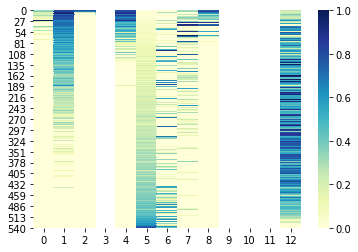

In [216]:
sns.heatmap(encoded_features/encoded_features.max(), cmap="YlGnBu")

In [217]:
concatenated = pd.concat([encoded_features.reset_index(drop=True),weather_df.iloc[:,14:].reset_index(drop=True)], axis=1, ignore_index=True)

In [218]:
colnames = weather_df.columns.values
colnames = np.delete(colnames, [13])
colnames[0:13]=range(13)
colnames[13:]=['Latitude', 'Longitude', 'Altitude', 'Heating degree days', 'Mean temperature', 'Std. temperature',
           'Mean humidity','Std. humidity', 'Mean solar radiation (hor.)', 'Std. solar radiation (hor.)']
corr = concatenated.corr()
corr.columns= colnames
concatenated.columns = colnames
corr.index=colnames

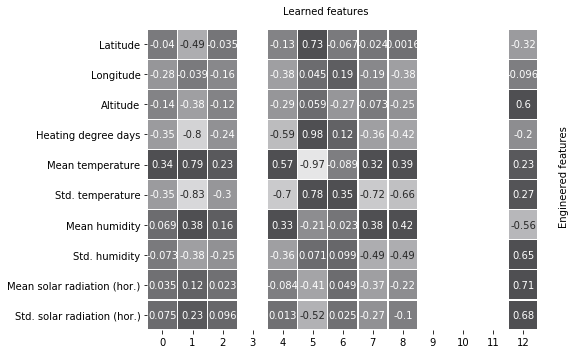

In [208]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0)#sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.iloc[13:,:13], cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar=False)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.text(4.5,-0.5,'Learned features')
plt.text(13.7,6.5,'Engineered features', rotation=90)
plt.show() # ta-da!

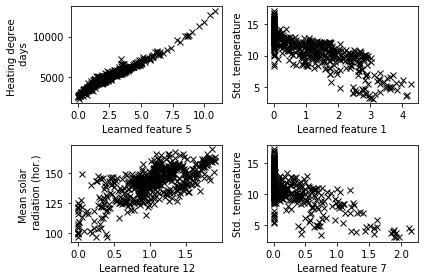

In [209]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].plot(concatenated[5],concatenated['Heating degree days'],'kx')
ax[0,0].set_ylabel('Heating degree \n days')
ax[0,0].set_xlabel('Learned feature 5')
ax[0,1].plot(concatenated[1],concatenated['Std. temperature'],'kx')
ax[0,1].set_ylabel('Std. temperature')
ax[0,1].set_xlabel('Learned feature 1')

ax[1,0].plot(concatenated[12],concatenated['Mean solar radiation (hor.)'],'kx')
ax[1,0].set_ylabel('Mean solar \n radiation (hor.)')
ax[1,0].set_xlabel('Learned feature 12')
ax[1,1].plot(concatenated[7],concatenated['Std. temperature'],'kx')
ax[1,1].set_ylabel('Std. temperature')
ax[1,1].set_xlabel('Learned feature 7')


plt.tight_layout()

### Generate, chain frames

In [233]:
%%time
intermediate_layer_model = Model(inputs=ann.input,
                                 outputs=[ann.layers[3].output,ann.layers[15].output,ann.layers[27].output,ann.layers[38].output])
intermediate_output = intermediate_layer_model.predict(weather_X)

CPU times: user 4min 23s, sys: 1min 14s, total: 5min 38s
Wall time: 29.6 s


In [221]:
cities = weather_df.iloc[:,13:16]
cities = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.longitude, cities.latitude))
cities.crs = {'init' :'epsg:4326'}
canada = gpd.read_file("/home/user/map_data/lpr_000b16a_e.shp").to_crs(epsg=4326)

In [267]:
def animate(i):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(30,4)) 
    ind = i*25
    sns.heatmap(intermediate_output[0][ind,:,:].transpose(), ax=ax1, cmap='Blues', vmin=-5, vmax=5, cbar=False)
    sns.heatmap(intermediate_output[1][ind,:,:].transpose(), ax=ax2, cmap='Blues', vmin=0, vmax=5, cbar=False)
    sns.heatmap(intermediate_output[2][ind,:,:].transpose(), ax=ax3, cmap='Blues', vmin=0, vmax=5, cbar=False)
    sns.heatmap(intermediate_output[3][ind,:,:].transpose(), ax=ax4, cmap='Blues', vmin=0, vmax=5, cbar=False)
    #sns.heatmap(intermediate_output[2][ind,:].reshape(1,-1).transpose(), ax=ax3, cmap='Blues', cbar=False)
    #sns.heatmap(intermediate_output[3][ind,:].reshape(1,-1).transpose(), ax=ax4, cmap='Blues', cbar=False)
    ax = canada.to_crs(epsg=3573).plot(edgecolor='black', ax=ax5)
    ax = cities.iloc[ind:ind+1,:].to_crs(epsg=3573).plot(ax=ax, markersize=120, color='red', edgecolor='black', linewidth=2)
    #plt.suptitle(weather_df.iloc[ind,13])
    #return (p,)
    #p.tick_params(labelsize=17)
    #plt.setp(p.lines,linewidth=7)
    plt.tight_layout()
    plt.savefig(f'Images/test{i}.png')
    plt.close()

In [268]:
%%time
for i in range(20):
    animate(i)

CPU times: user 11min 34s, sys: 17.4 s, total: 11min 52s
Wall time: 11min 33s


In [11]:
from PIL import Image
frames = []
for i in range(44):
    frames.append(Image.open(f"Images/test{i}.png"))

# Save into a GIF file that loops forever
frames[0].save('moving_ball_new_model.gif', format='GIF', append_images=frames[1:], save_all=True, duration=1000, loop=0)

In [12]:
sns.heatmap(intermediate_output[1][ind,:,:].transpose(), ax=ax2, cmap='Blues', vmin=0, vmax=1500, cbar=False)

NameError: name 'ind' is not defined

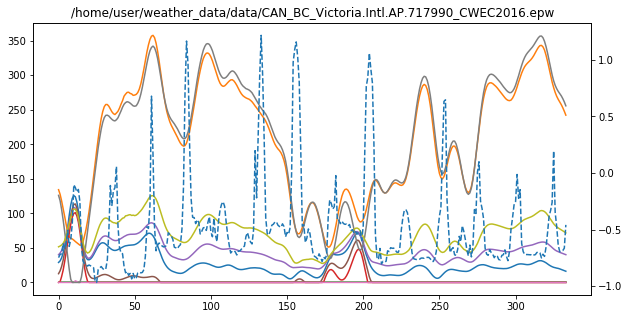

In [13]:
start=240
end=574
location = 44
plt.figure(figsize=(10,5))
plt.title(weather_df.iloc[location,13])
plt.plot(intermediate_output[1][location,start:end,12])
plt.plot(intermediate_output[1][location,start:end,14])
plt.plot(intermediate_output[1][location,start:end,15])
plt.plot(intermediate_output[1][location,start:end,23])
plt.plot(intermediate_output[1][location,start:end,24])
plt.plot(intermediate_output[1][location,start:end,27])
plt.plot(intermediate_output[1][location,start:end,28])
plt.plot(intermediate_output[1][location,start:end,29])
plt.plot(intermediate_output[1][location,start:end,30])
plt.twinx()
plt.plot(intermediate_output[0][location,start:end,0],'--')

In [77]:
weather_df.iloc[300:360,13]

983     /home/user/weather_data/data/CAN_ON_Big.Trout....
6       /home/user/weather_data/data/CAN_ON_Thunder.Ba...
493     /home/user/weather_data/data/CAN_ON_Thunder.Ba...
551     /home/user/weather_data/data/CAN_ON_Armstrong....
894     /home/user/weather_data/data/CAN_ON_Cameron.Fa...
153     /home/user/weather_data/data/CAN_ON_Lansdowne....
325     /home/user/weather_data/data/CAN_ON_Geraldton-...
268     /home/user/weather_data/data/CAN_ON_Pukaskwa.N...
182     /home/user/weather_data/data/CAN_NU_Eureka.AP....
1226    /home/user/weather_data/data/CAN_ON_Peawanuck....
762     /home/user/weather_data/data/CAN_ON_Wawa.Muni....
14      /home/user/weather_data/data/CAN_ON_Sault.Ste....
1026    /home/user/weather_data/data/CAN_ON_Sault.Ste....
690     /home/user/weather_data/data/CAN_ON_Nagagami.7...
322     /home/user/weather_data/data/CAN_NU_Coral.Harb...
100     /home/user/weather_data/data/CAN_ON_Windsor.In...
725     /home/user/weather_data/data/CAN_ON_Windsor.In...
128     /home/

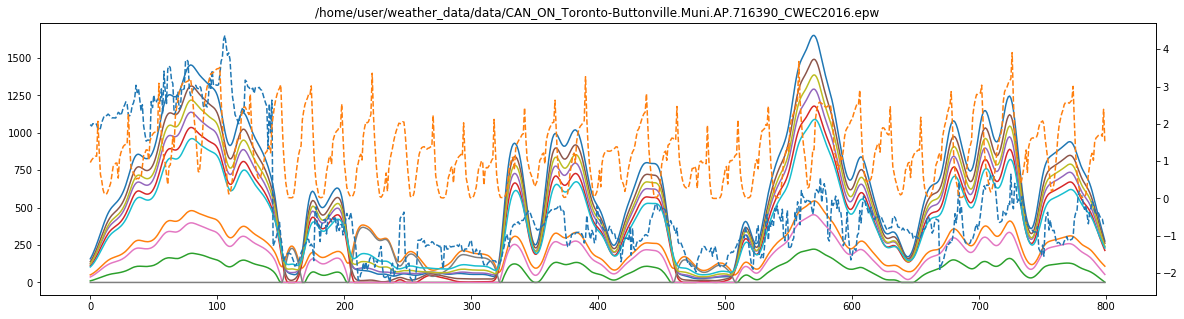

In [135]:
start=600
end=1400
location = 351 #Toronto: 351, Victoria: 51
plt.figure(figsize=(20,5))
plt.title(weather_df.iloc[location,13])
plt.plot(intermediate_output[1][location,start:end,12])
plt.plot(intermediate_output[1][location,start:end,14])
plt.plot(intermediate_output[1][location,start:end,15])
plt.plot(intermediate_output[1][location,start:end,23])
plt.plot(intermediate_output[1][location,start:end,24])
plt.plot(intermediate_output[1][location,start:end,27])
plt.plot(intermediate_output[1][location,start:end,28])
plt.plot(intermediate_output[1][location,start:end,29])
plt.plot(intermediate_output[1][location,start:end,30])
plt.plot(intermediate_output[1][location,start:end,45])
plt.twinx()
plt.plot(intermediate_output[0][location,start:end,7],'--')
plt.plot(df_new.values[start:end]/1e8,'--')

In [110]:
epw_path = weather_df.iloc[location, 13]
params = parameters[23][:-2]
building = ef.get_building(parameters[23][-2])
output_set = parameters[23][-1]
problem = EPProblem(params, output_set)
X = pd.DataFrame(standardization[1].inverse_transform(weather_X[location,-13:].reshape(1,13)), columns=params)
evaluator = EvaluatorEP(problem, building, epw=epw_path, multi=False, out_dir='Transfer_folder')
y_part = evaluator.df_apply(X)

In [111]:
import os
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

In [112]:
# Connect to SQL
sql_path = 'Transfer_folder/BESOS_Output/eplusout.sql'
conn = sqlite3.connect(sql_path)

# Define Queries
def select_all_from_table(table_name):
    q = "SELECT * FROM {}".format(table_name)
    return pd.read_sql(q, conn)

def select_tabular_report(report_name, table_name=None):
    q = "SELECT * FROM TabularDataWithStrings WHERE ReportName='{}'".format(report_name)
    if table_name:
        q = q + " and TableName='{}'".format(table_name)
    return pd.read_sql(q, conn)

def select_tables():
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    return pd.read_sql(query ,conn)

In [113]:
reporting_frequencies = ['Zone Timestep', 'Hourly', 'Daily', 'Monthly']
index_groups = ['Facility:DistrictHeating', 'Facility:Electricity', 'Zone', 'Facility:DistrictCooling']

def zero_index_minutes(row):
    minute = row['Minute']
    hour = row['Hour']
    
    minute_new = minute
    return row

def index_time_series(df, frequency):
    if frequency == 'Monthly':
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '/' + 
            df['Month'].astype(str) + 
            '/01'
        )
    elif frequency == 'Daily':
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '/' + 
            df['Month'].astype(str) + '/' + 
            df['Day'].astype(str)
        )
    elif frequency == 'Hourly':
        df['Hour'] = df['Hour'] - 1
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '/' + 
            df['Month'].astype(str) + '/' + 
            df['Day'].astype(str) + ' ' +
            df['Hour'].astype(str) + ':00'
        )
    else:
        df['Minute'] = df['Minute'] - 10
        df.loc[df.Minute < 0, 'Hour'] = df.loc[df.Minute < 0, 'Hour'] - 1
        df.loc[df.Minute < 0, 'Minute'] = 50
        
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '/' + 
            df['Month'].astype(str) + '/' + 
            df['Day'].astype(str) + ' ' +
            df['Hour'].astype(str) + ':' +
            df['Minute'].astype(str)
        )
    
    return df['Date']


def select_time_series(reporting_frequency, index_group, convert_j=False):
    q = "SELECT * FROM ReportData as RD " \
        "JOIN ReportDataDictionary as RDD on RD.ReportDataDictionaryIndex = RDD.ReportDataDictionaryIndex " \
        "JOIN Time as T on T.TimeIndex = RD.TimeIndex " \
        "AND RDD.ReportingFrequency == '{}' " \
        "AND IndexGroup == '{}' ".format(reporting_frequency, index_group)
    
    df = pd.read_sql(q, conn)
    df.index = index_time_series(df, reporting_frequency)
    
    df.Value = pd.to_numeric(df.Value)

    if convert_j:
        df.loc[df.Units == 'J', 'Value'] = df.loc[df.Units == 'J', 'Value'].apply(j_to_kwh)
        df.loc[df.Units == 'J', 'Units'] = 'kWh'
    return df


heating_time_series = select_time_series('Zone Timestep', 'Facility:DistrictHeating')
cooling_time_series = select_time_series('Zone Timestep', 'Facility:DistrictCooling')

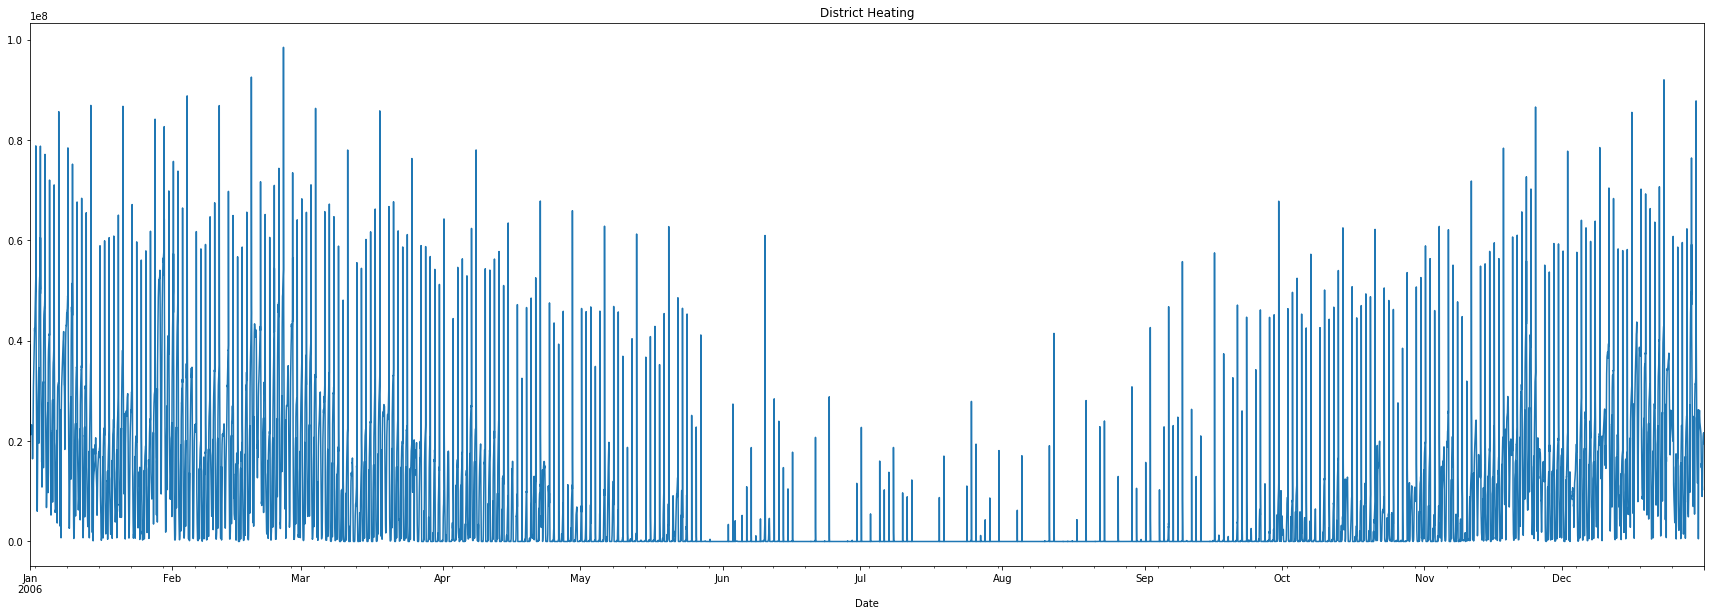

In [114]:
#print('Total Heating (kWh/m2)', heating_time_series['Value'].sum() / get_total_floor_area() )
heating_time_series['Value'].plot(figsize=(30,10), title='District Heating')

In [115]:
df_new = heating_time_series['Value'].resample('H').sum()

In [122]:
np.shape(h.data)

(4993200, 10)

In [123]:
df, metadata = pvlib.iotools.read_epw(epw_path)

In [127]:
columns_to_drop = ['year', 'month', 'day', 'hour', 'minute', 'data_source_unct', 
                       'present_weather_observation', 'precipitable_water', 'days_since_last_snowfall', 
                       'liquid_precipitation_depth', 'liquid_precipitation_quantity', 'etrn', 'zenith_luminance', 
                       'aerosol_optical_depth', 'albedo', 'ceiling_height', 'present_weather_codes', 'visibility']

In [128]:
df.drop(columns=columns_to_drop).columns

Index(['temp_air', 'temp_dew', 'relative_humidity', 'atmospheric_pressure',
       'etr', 'ghi_infrared', 'ghi', 'dni', 'dhi', 'global_hor_illum',
       'direct_normal_illum', 'diffuse_horizontal_illum', 'wind_direction',
       'wind_speed', 'total_sky_cover', 'opaque_sky_cover', 'snow_depth'],
      dtype='object')

## Visualize Weather time series

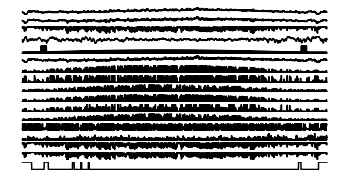

In [40]:
fig,ax = plt.subplots(17,1, figsize=(6,3))

for i,n in enumerate(range(17)):
    ax[i].plot(intermediate_output[0][0][:,n],'k')
    ax[i].axis('off')
    
plt.savefig('building_ts_all.svg')

# Visualize world map

In [44]:
lon = weather_df.longitude
lat = weather_df.latitude
heating_demand = ann.predict(weather_X)

In [45]:
import pickle
pickle.dump([lon.values, lat.values, np.exp(standardization[2].inverse_transform(heating_demand)).ravel()*2.77778e-7], open('temp.p','wb'))

In [20]:
canada = gpd.read_file("/home/user/map_data/lpr_000b16a_e.shp").to_crs(epsg=4326)
canada['performance'] = heating_demand

ValueError: Length of values does not match length of index

KeyError: 'performance'

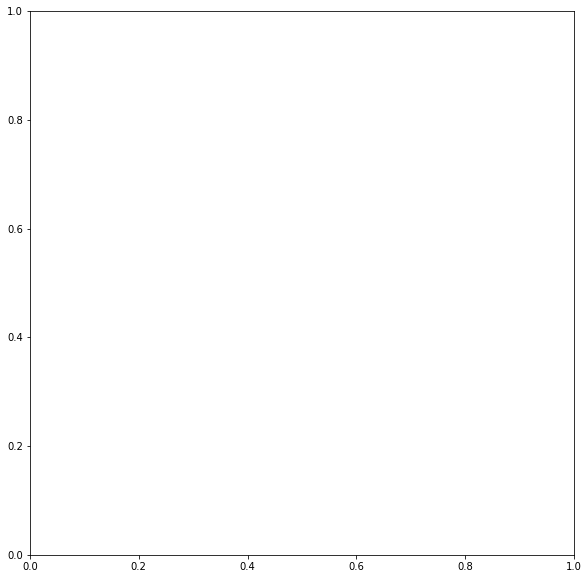

In [63]:
fig, ax = plt.subplots(1, figsize=(15, 10))
ax = canada.to_crs(epsg=3573).plot(ax=ax, edgecolor='black', figsize=(20,10), cmap='RdYlGn_r', column='performance', vmin=0, vmax=30, legend=True)
# ax = cities.to_crs(epsg=3573).plot(ax=ax, edgecolor='black', linewidth=2, cmap='Reds', column='performance', vmin=0, vmax=50, legend=True, s=75)
#ax = gpd_object.to_crs(epsg=3573).plot(ax=ax, edgecolor='black', linewidth=2, cmap='RdYlGn_r', column='performance', vmin=0, vmax=30, s=75)
